# Data generation

Read raw data from `FinalInstance` dir and conver to be fit our model. I also assign the correspoinding data profile.

In [1]:
using Pkg, JuMP, StatsBase, DataFrames, CSV, DelimitedFiles, PyPlot, Statistics, FileIO, JLD2
using LightGraphs, GraphPlot, Colors  # for plotting graph

include("../src/load_function.jl"); # src code for loading network data

In [2]:
# read data of low&medium voltage network from FinalInstance
LVChildrenNodes, LVLoadNodeDict, LVg = ReadSubnetworkData("../data/FinalInstance/LowVoltage/Nodes.txt",
        "../data/FinalInstance/LowVoltage/Edges.txt");
MVChildrenNodes, MVLoadNodeDict, MVg = ReadSubnetworkData("../data/FinalInstance/MediumVoltage/Nodes.txt",
        "../data/FinalInstance/MediumVoltage/Edges.txt",true);

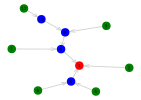

In [3]:
colormap = [colorant"blue",colorant"red",colorant"green",colorant"orange"]
LVmembership = ones(Int64,nv(LVg)); MVmembership = ones(Int64,nv(MVg)); 
LVmembership[1] = 2; MVmembership[1] = 2; # root node
LVmembership[collect(keys(LVLoadNodeDict))] .= 3; # nodes with load 
MVmembership[collect(keys(MVLoadNodeDict))] .= 3; # nodes with load 
gplot(LVg,nodelabel=collect(1:nv(LVg)),nodefillc=colormap[LVmembership])

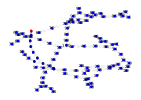

In [4]:
gplot(MVg,nodelabel=collect(1:nv(MVg)),nodefillc=colormap[MVmembership])

### Demand data 

In [5]:
d1 = readdlm("../data/RawDemandSimulation/15m_demand_oct_1.csv",',',Float64);
d2 = readdlm("../data/RawDemandSimulation/15m_demand_oct_2.csv",',',Float64);
d3 = readdlm("../data/RawDemandSimulation/15m_demand_oct_3.csv",',',Float64);
d4 = readdlm("../data/RawDemandSimulation/15m_demand_oct_4.csv",',',Float64);
d5 = readdlm("../data/RawDemandSimulation/15m_demand_oct_5.csv",',',Float64);

Max of average demand 

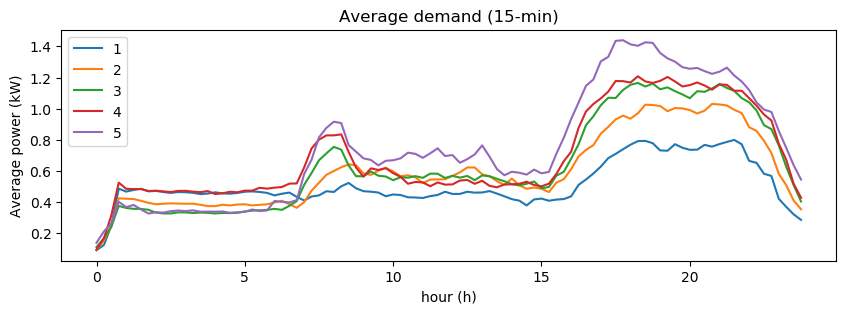

[0.799205, 1.03024, 1.16538, 1.2078, 1.43951]


In [6]:
demands = [d1,d2,d3,d4,d5]
average_max_demand = zeros(5);
fig = figure(figsize=(10,3))
# subplot(121)
for i in 1:length(demands)
    plot(range(0,stop=23.75,length=96),mean(demands[i],dims=1)[:],label=i)
    average_max_demand[i] = maximum(mean(demands[i],dims=1)[:])
end
xlabel("hour (h)")
ylabel("Average power (kW)")
title("Average demand (15-min)")
legend()
show()
println("Max of average demand ",average_max_demand)

The maximum demand of the average power increases by the number of residents.


In [7]:
LVLoadNodeDict

Dict{Int64,Float64} with 6 entries:
  7  => 1.43001
  9  => 0.680007
  2  => 2.12002
  11 => 0.770008
  5  => 2.49002
  6  => 0.810008

In [8]:
MVLoadNodeDict

Dict{Int64,Float64} with 0 entries

#### Low voltage network
* 6 nodes of Low voltage network have demand.
    - Node with small nominal load (< 1kW): node 6, 9, 11
    - Node with normal nominal load: node 7   
    - Node with large nominal load (> 2kW): node 2, 5
    
Since the average of persons per household, 2013-2017 is **2.96** (source https://www.census.gov/quickfacts/fact/table/ca# ), I assign the number of residents as follows:   
- 1: node 9, 11
- 2: node 6
- 4: node 7
- 5: node 2, 5  

Then its average is **3.0**.

#### Medium voltage network    
* There are no load in the medium voltage network. -> No assignment of demand data.

### Assignment of load for low voltage network

In [9]:
number_of_residents = Dict(9=>1,11=>1,6=>2,7=>4,2=>5,5=>5)

Dict{Int64,Int64} with 6 entries:
  7  => 4
  9  => 1
  2  => 5
  11 => 1
  5  => 5
  6  => 2

Find the simulation results which have the **closest peak load** to the data.   
<del> Select the simulation results **randomly**</del>   

In [10]:
LVDemandDataDict = Dict()
for n in collect(keys(LVLoadNodeDict))
    maxl = LVLoadNodeDict[n]
    idx = argmin(abs.(maximum(demands[number_of_residents[n]],dims=2)[:] .- LVLoadNodeDict[n]))
#     idx = sample(1:1000) # if random sample
    select_data = demands[number_of_residents[n]][idx,:];
    LVDemandDataDict[n] = select_data/maximum(select_data) * maxl;
    println("node id: ", n," nominal load: ",maxl," index of chosen data: ",idx,
        " max load in data: ", round(maximum(select_data),digits=6),
        " scaled max load: ", round(maximum(LVDemandDataDict[n]),digits=6))
end

node id: 7 nominal load: 1.43001 index of chosen data: 317 max load in data: 1.432667 scaled max load: 1.43001
node id: 9 nominal load: 0.680007 index of chosen data: 969 max load in data: 0.6842 scaled max load: 0.680007
node id: 2 nominal load: 2.12002 index of chosen data: 696 max load in data: 2.128 scaled max load: 2.12002
node id: 11 nominal load: 0.770008 index of chosen data: 243 max load in data: 0.7692 scaled max load: 0.770008
node id: 5 nominal load: 2.49002 index of chosen data: 76 max load in data: 2.485067 scaled max load: 2.49002
node id: 6 nominal load: 0.810008 index of chosen data: 829 max load in data: 0.8316 scaled max load: 0.810008


In [11]:
LVDemandDataDict

Dict{Any,Any} with 6 entries:
  7  => [0.0509054, 0.0509054, 0.0509054, 0.0509054, 0.0509054, 0.0509054, 0.05…
  9  => [0.0576446, 0.0576446, 0.0576446, 0.0576446, 0.0576446, 0.0576446, 0.05…
  2  => [0.0547938, 0.0547938, 0.0547938, 0.0695383, 0.165377, 0.148242, 0.2054…
  11 => [0.0510536, 0.0510536, 0.0959006, 0.287969, 0.13968, 0.0510536, 0.09349…
  5  => [0.133599, 0.0400797, 0.0400797, 0.0400797, 0.130393, 0.175549, 0.17554…
  6  => [0.0409095, 0.0631175, 0.174158, 0.115715, 0.227924, 0.0533772, 0.04090…

In [12]:
for n in collect(keys(LVLoadNodeDict))
    println("node id: ", n, " total energy (kWh): ", sum(LVDemandDataDict[n])/4)
end
println("\noverall energy (kWh): ", sum(sum(values(LVDemandDataDict)))/4)

node id: 7 total energy (kWh): 6.671222896347139
node id: 9 total energy (kWh): 3.1571990207541654
node id: 2 total energy (kWh): 11.330152000000002
node id: 11 total energy (kWh): 4.809313270237476
node id: 5 total energy (kWh): 9.247512507645665
node id: 6 total energy (kWh): 4.707919874138206

overall energy (kWh): 39.92331956912266


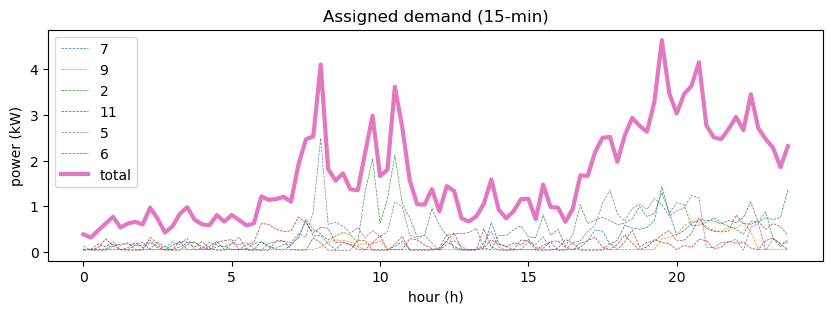

In [13]:
fig = figure(figsize=(10,3))
timestages =range(0,stop=23.75,length=96)
total = zeros(96);
for k in keys(LVDemandDataDict)
    plot(timestages,LVDemandDataDict[k],label=k,"--",linewidth = 0.5)
    total += LVDemandDataDict[k]
end
plot(timestages,total,label="total",linewidth = 3)
legend()
xlabel("hour (h)")
ylabel("power (kW)")
title("Assigned demand (15-min)")
show()

## Assignment of PV and Storage

Here I assign the rooftop solar and battery storage for residents.  
Recall we consider the penetration of rooftop solar and battery is 20%.

However since there are six houses in the low voltage network, I would assign two of them, i.e. **33% of housings have the solar and battery**.   
And those two housings are the houses with the highest demand, hence node 2 and 5.

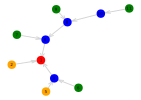

In [14]:
LVmembership[2] = 4; LVmembership[5] = 4;
gplot(LVg,nodelabel=collect(1:nv(LVg)),nodefillc=colormap[LVmembership])
# orange nodes are the houses with PV and battery

Load the PV capcacity data from NEM.

In [15]:
pv_capacity = readdlm("../../../Dropbox/Symmetric DN/PV_capacity_data.csv");

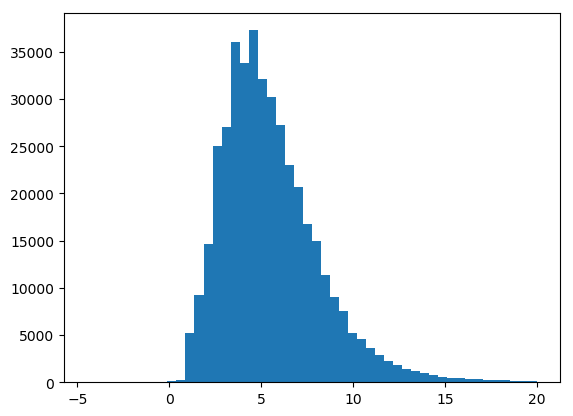

(5.509888276040867, 5.052)

In [16]:
hist(pv_capacity,50)
show()
mean(pv_capacity), median(pv_capacity)

Let's say node 2 has the capacity of **5.5 kW** and node 5 has the capacity of **5.0 kW**.

In [17]:
LVPVNodeDict = Dict(2 => 5.5, 5 =>5.0)

Dict{Int64,Float64} with 2 entries:
  2 => 5.5
  5 => 5.0

## Capacity of the feeder

We set the capacity of the feeder as 100% of the maximum load.

In [18]:
# maximum load in one branch of MV network
max_branch_load =  maximum(total) * (nv(MVg)-1)

458.9364853966538

Let's say there are **five branches** of medium voltage network. Then, the total maximum load is:

In [19]:
NBranches = 5
max_branch_load * NBranches

2294.6824269832687

Hence the max load of the entire network is about 2.23 MW

In [20]:
feeder_capacity = max_branch_load * NBranches * 1.0

2294.6824269832687

## save data as JLD2

In [21]:
# save("../data/Case1/network_data.jld2","LVChildrenNodes",LVChildrenNodes,"LVLoadNodeDict" ,LVLoadNodeDict,
#     "MVChildrenNodes",MVChildrenNodes, "MVLoadNodeDict",MVLoadNodeDict,
#     "LVDemandDataDict",LVDemandDataDict,"LVPVNodeDict", LVPVNodeDict, "NBranches",NBranches, "feeder_capacity",feeder_capacity)